In [231]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from scipy.io import wavfile
import matplotlib.pyplot as plt
from keras.utils import to_categorical

from scipy.io import loadmat
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


## Loading Files

In [390]:
def load_files(folder_path, bird_name):
    files = []
    wav_files = glob.glob(folder_path + "/" + bird_name + "*.wav")
    for wav_file in wav_files:
        file_dic = {}
        file_dic['wav_file'] = wav_file
        sr, data = wavfile.read(wav_file)
        file_dic['audio'] = data
        file_dic['sr'] = sr
        file_dic['dur'] = len(data)
        file_dic['dur_ms'] = int(len(data)/sr*1000)
        file_dic['bird_name'] = wav_file[8:wav_file.find("_")]
        mat = loadmat(wav_file + ".not.mat")
        try:
            labels = mat['labels'][0]
            onsets = mat['onsets']
            offsets = mat['offsets']
        except:
            print(wav_file)
            continue
        file_dic['notes'] = [{'label': '!', 
                              'onset': max(onsets[0][0] - 50,0) , 
                              'offset': onsets[0][0],
                              'length': onsets[0][0]-max(onsets[0][0] - 50,0)}] #labelling the background
        for i in range(len(labels)):
            not_data = {}
            not_data['label'] = labels[i]
            not_data['onset'] = onsets[i][0]
            not_data['offset'] = offsets[i][0]
            not_data['length'] = offsets[i][0] - onsets[i][0]
            file_dic['notes'].append(not_data)
        files.append(file_dic)
    df = pd.DataFrame(files)
    return df, files

In [391]:
bird_name = "pu42g12" #"r39y3" #g65b65
df, files = load_files("./songs", bird_name)

In [392]:
files[1]

{'wav_file': './songs/pu42g12_July_13_2017_40870503.wav',
 'audio': array([20, 30, 39, ..., 24, 20,  8], dtype=int16),
 'sr': 44100,
 'dur': 817620,
 'dur_ms': 18540,
 'bird_name': 'pu42g12',
 'notes': [{'label': '!',
   'onset': 2281.8820861678,
   'offset': 2331.8820861678,
   'length': 50.0},
  {'label': '-',
   'onset': 2331.8820861678,
   'offset': 2354.081632653061,
   'length': 22.19954648526118},
  {'label': '-',
   'onset': 2508.7755102040815,
   'offset': 2553.0385487528347,
   'length': 44.26303854875323},
  {'label': '-',
   'onset': 2749.795918367347,
   'offset': 2798.4126984126983,
   'length': 48.616780045351334},
  {'label': '-',
   'onset': 2921.1111111111113,
   'offset': 2983.310657596372,
   'length': 62.199546485260726},
  {'label': '-',
   'onset': 3093.9909297052154,
   'offset': 3152.4036281179137,
   'length': 58.41269841269832},
  {'label': '-',
   'onset': 3254.263038548753,
   'offset': 3317.3469387755104,
   'length': 63.08390022675758},
  {'label': '-',
 

In [393]:
#max length in ms
max_len_ms = int(df['dur'].max()/44100*1000)
max_len_ms

31798

In [394]:
#Padding the audios to the max length
max_dur = df['dur'].max()
for file in files:
    pad_len = max_dur - file['dur']
    padded_audio = np.pad(file['audio'], (0,pad_len),'constant')
    file['audio'] = padded_audio
    file['dur'] = len(padded_audio)

In [395]:
files[30]

{'wav_file': './songs/pu42g12_July_16_2017_38786680.wav',
 'audio': array([ 6, 10, 12, ...,  0,  0,  0], dtype=int16),
 'sr': 44100,
 'dur': 1402324,
 'dur_ms': 10845,
 'bird_name': 'pu42g12',
 'notes': [{'label': '!',
   'onset': 2944.1043083900227,
   'offset': 2994.1043083900227,
   'length': 50.0},
  {'label': '-',
   'onset': 2994.1043083900227,
   'offset': 3012.630385487528,
   'length': 18.52607709750555},
  {'label': '-',
   'onset': 3191.1791383219957,
   'offset': 3239.092970521542,
   'length': 47.913832199546505},
  {'label': '-',
   'onset': 3360.8843537414964,
   'offset': 3403.4240362811793,
   'length': 42.53968253968287},
  {'label': '-',
   'onset': 3561.9274376417234,
   'offset': 3607.8004535147393,
   'length': 45.8730158730159},
  {'label': '-',
   'onset': 3806.0090702947846,
   'offset': 3853.6281179138323,
   'length': 47.619047619047706},
  {'label': '-',
   'onset': 3952.7891156462583,
   'offset': 4004.648526077098,
   'length': 51.85941043083949},
  {'labe

In [396]:
def make_x(file):
    data = file['audio']
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    x, _, _, _ = plt.specgram(data, nfft, fs, noverlap = noverlap, sides='onesided', mode='psd')
    return np.transpose(x)

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(17527, 101)

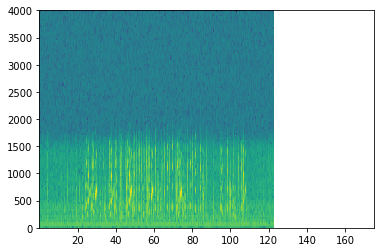

In [397]:
xtest = make_x(files[0])
xtest.shape

In [398]:
y_labels = set()
for file in files:
    for note in file['notes']:
        y_labels.add(note['label'])
y_lab_to_int = {lab: i for i,lab in enumerate(y_labels)}     
y_int_to_lab = {i: lab for i,lab in enumerate(y_labels)}
num_classes = len(y_labels)

63 4379 17527 101


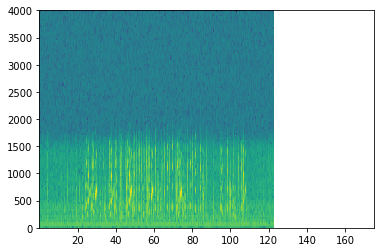

In [409]:
m = len(files)
Tx,n_freqs = make_x(files[0]).shape
Ty = 4379#1375
print(m, Ty, Tx, n_freqs)

In [410]:
def insert_labels(file):
    y = np.zeros((1,Ty))
    notes = file['notes']
    for note in notes:
        label = y_lab_to_int[note['label']]
        onset = int(note['onset'])
        offset = int(note['offset'])
        segment_start_y = int(onset * Ty / max_len_ms)
        segment_end_y = int(offset * Ty / max_len_ms)
        for ty in range(segment_start_y, segment_end_y):
            y[0,ty] = label
    y = to_categorical(y,num_classes=num_classes)
    return y

In [411]:
ytest = insert_labels(files[0])
ytest[0,0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

(63, 4379, 26)
(63, 17527, 101)


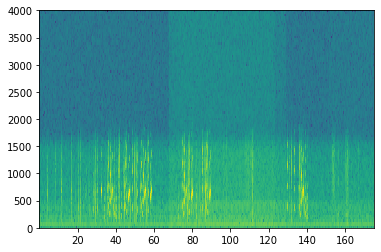

In [412]:
X = np.zeros((m,Tx,n_freqs))
Y = np.zeros((m,Ty, num_classes))

for t in range(m):
    X[t,:,:] = make_x(files[t])
    Y[t,:,:] = insert_labels(files[t])
print(Y.shape)
print(X.shape)

In [413]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [414]:
def model(input_shape):
    X_input = Input(shape = input_shape)

    X = Conv1D(filters=196,kernel_size=15,strides=4)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(rate=0.2)(X)                                 # dropout (use 0.8)

#     X = GRU(units=128, return_sequences=True)(X)              # GRU (use 128 units and return the sequences)
    X = Bidirectional(LSTM(units=128, return_sequences=True))(X)
    X = Dropout(rate=0.2)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
#     X = GRU(units=128, return_sequences=True)(X)                   # GRU (use 128 units and return the sequences)
    X = Bidirectional(LSTM(units=128, return_sequences=True))(X)
    X = Dropout(rate=0.2)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(rate=0.2)(X)                                 # dropout (use 0.8)
    
    X = TimeDistributed(Dense(num_classes, activation='softmax'))(X) # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [415]:
model = model(input_shape = (Tx, n_freq))

In [416]:
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 17527, 101)        0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 4379, 196)         297136    
_________________________________________________________________
batch_normalization_49 (Batc (None, 4379, 196)         784       
_________________________________________________________________
activation_19 (Activation)   (None, 4379, 196)         0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 4379, 196)         0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 4379, 256)         332800    
_________________________________________________________________
dropout_67 (Dropout)         (None, 4379, 256)         0  

In [417]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [ ]:
model.fit(X, Y, batch_size = 5, epochs=10)

Epoch 1/10
63/63 [==============================] - 275s 4s/step - loss: 3.5647 - accuracy: 0.2914
Epoch 2/10
63/63 [==============================] - 274s 4s/step - loss: 2.7741 - accuracy: 0.6603
Epoch 3/10
63/63 [==============================] - 324s 5s/step - loss: 2.3825 - accuracy: 0.7180
Epoch 4/10
63/63 [==============================] - 297s 5s/step - loss: 2.0448 - accuracy: 0.7509
Epoch 5/10
20/63 [========>.....................] - ETA: 2:57 - loss: 1.9129 - accuracy: 0.7456

In [389]:
model.save('model_'+bird_name+'_RNN.h5')